In [1]:
%matplotlib inline

import math
import random

import matplotlib.pyplot as plt
import numpy as np
import numba

In [2]:
L = 10 # system size in one direction
J = 1 # lattice bond energy
temperature = 2 # temperature to simulate
beta = 1/temperature # inverse temperature, setting Boltzmann constant to 1

In [3]:
def calculate_energy(lattice):
    """Calculate the energy of a lattice using the Ising model Hamiltonian."""
    energy = 0
    for y in range(L):
        for x in range(L):
            center = lattice[y][x]
            neighbours = [(y, (x-1)%L) ,(y, (x+1)%L), ((y-1)%L, x), ((y+1)%L, x)]
            for n in neighbours:
                if lattice[n] == center:
                    energy += J
        
    return energy

In [4]:
def exponents_init():
    exponents = {}
    for x in range(2, 5, 2):
        exponents[2*J*x] = math.exp(-beta * 2 * J * x)
    
    return exponents

sweep 0
sweep 100
sweep 200


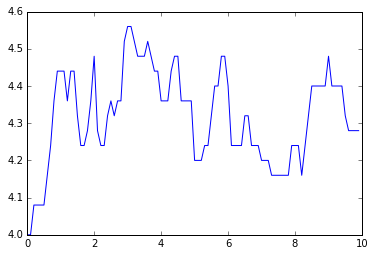

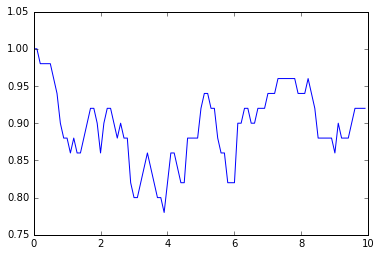

In [6]:
def metropolis(sweeps):
    energy_history = []
    magnet_history = []
    exponents = exponents_init()
    
    lattice = np.ones(L*L).reshape(L, L) # initial temperature is 0
    # lattice = np.random.choice([-1, 1], L*L).reshape(L, L) # infinite initial temperature
    
    energy = calculate_energy(lattice) # calculate initial energy of the lattice
    for t in range(sweeps):
        for k in range(L*L):

            rand_y, rand_x = random.randrange(L), random.randrange(L) # pick a random location on the lattice

            spin = lattice[rand_y, rand_x] # get the spin at that random location

            # determine the energy delta from flipping that spin
            neighbours = [(rand_y, (rand_x-1)%L) ,(rand_y, (rand_x+1)%L), ((rand_y-1)%L, rand_x), ((rand_y+1)%L, rand_x)]
            spin_sum = 0
            for n in neighbours:
                spin_sum += lattice[n]
            energy_delta = 2*J*spin*spin_sum
            
            
    
            if energy_delta <= 0:
                acceptance_probability = 1
            else:
                acceptance_probability = exponents[energy_delta]

            if random.random() <= acceptance_probability:
                lattice[rand_y, rand_x] = -1*spin
                energy += energy_delta
            energy_history.append((t+k/(L*L), energy))
            magnet_history.append((t+k/(L*L), np.sum(lattice)))
            
        if t % 100==0:
            print("sweep", t)

    return energy_history, magnet_history

# %timeit metropolis(1000)
energy_history, magnet_history = metropolis(250)
plt.plot([x[0] for x in energy_history[:100*L:L]], [(y[1]/(L*L)) for y in energy_history[:100*L:L]])
plt.show()
plt.plot([x[0] for x in magnet_history[:100*L:L]], [(y[1]/(L*L)) for y in magnet_history[:100*L:L]])
plt.show()
            

In [21]:
@numba.jit
def auto_correlation(t, data):
    tmax = len(data)
    time_delta = data[1][0] - data[0][0]
    
    upper_bound = tmax-t
    first_sum = 0
    second_sum = 0
    third_sum = 0
    for n in range(upper_bound):
        first_sum += data[n][0]*data[n+t][0]
        second_sum += data[n][0]
        third_sum += data[n+t][0]
    
    correlation = (1/upper_bound)*(first_sum - (1/upper_bound)*second_sum*third_sum)

    return correlation

%timeit auto_correlation(1000, magnet_history)

The slowest run took 157.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.23 ms per loop


In [48]:
data = np.asarray([auto_correlation(p, magnet_history) for p in range(12500)])
normalize = data / data.max()

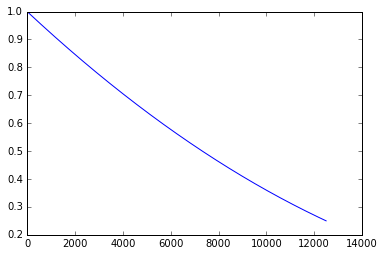

In [49]:
plt.plot(range(len(data)), normalize)

In [42]:
np.trapz(normalize)*0.01

83.333333133341313

In [40]:
print(magnet_history[:10])

[(0.0, 100.0), (0.01, 100.0), (0.02, 100.0), (0.03, 100.0), (0.04, 100.0), (0.05, 100.0), (0.06, 100.0), (0.07, 100.0), (0.08, 100.0), (0.09, 100.0)]


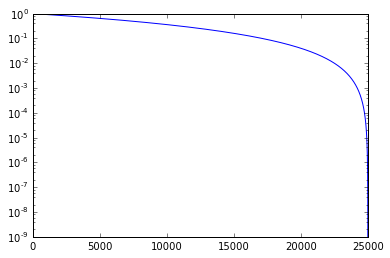

In [44]:
plt.plot(range(len(data)), normalize)
plt.yscale("log")